## Estadística Aplicada

Nombre: Barbara Govea Serna

Matrícula: 1902869

Grupo: 042

Actividad para exentar la elaboración del PIA

In [359]:
# Librerias básicas 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
%matplotlib inline

In [360]:
# Librerias especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima import auto_arima

In [361]:
# Formato de gráficas
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=12

## 1. Descargar la base de datos con base en el video adjunto, se debe elegir un periodo y en la notebook se debe justificar el periodo elegido

In [362]:
IMCP_base=pd.read_csv('Indicadores2023.csv') 

In [363]:
ultima_obs = IMCP_base.loc[66]
IMCP_base = IMCP_base[:66]
IMCP_base

,Periodos,IMCM
0,2018/01,99.768318
1,2018/02,99.827410
2,2018/03,100.044212
3,2018/04,99.707154
4,2018/05,99.927769
...,...,...
61,2023/02,106.400587
62,2023/03,106.762443
63,2023/04,107.928291
64,2023/05,107.775653


Para estimar el Indicador Mensual del Consumo Privado tomamos datos historicos de 5 años, un periodo lo suficientemente amplio para observar y comprender las tendencias, además son los datos mas recientes para lograr estimación precisa. De INEGI, tomamos los datos desestacionalizado para analizar tendencias que puedan estar relacionadas con el crecimiento económico a largo plazo, las tendencias demograficas o las preferencias del consumidor, con eso también eliminamos efectos estacionales que no son recomendados para realizar estimaciones

## 2. Verificar tipo de variables y no existencia de missing values

In [364]:
IMCP_base.dtypes

Periodos     object
IMCM        float64
dtype: object

In [365]:
IMCP_base.isna().sum()

Periodos    0
IMCM        0
dtype: int64

In [366]:
# Formato fecha
IMCP_base['Periodos']=pd.to_datetime(IMCP_base['Periodos'],format='%Y/%m')
IMCP_base.head(1)

,Periodos,IMCM
0,2018-01-01,99.768318


In [367]:
# Fecha index
IMCP_base=IMCP_base.set_index('Periodos') 
IMCP_base.head(1)


,IMCM
Periodos,
2018-01-01,99.768318


In [368]:
# Asignar una frecuencia
IMCP_base=IMCP_base.asfreq('MS')

## 3. Gráfico de la serie (títulos, nombre a ejes etc)

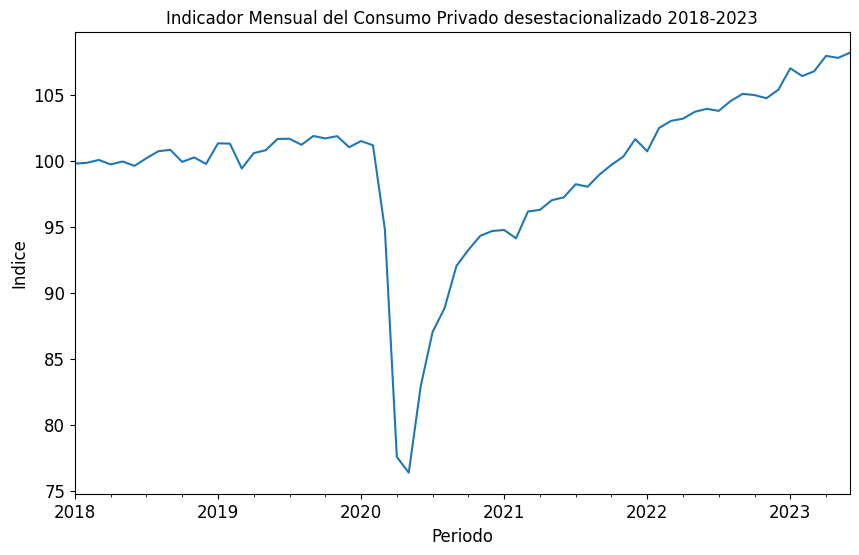

In [369]:
IMCP_base['IMCM'].plot()
plt.title('Indicador Mensual del Consumo Privado desestacionalizado 2018-2023')
plt.ylabel('Indice')
plt.xlabel('Periodo')
plt.show()

## 4. Realiza un pronóstico del índice:

### a) Realiza una prueba de raíz unitaria a la serie original

PRUEBA DE DICKEY FULLER AUMENTADA

In [370]:
prueba_DFA=adfuller(IMCP_base['IMCM'])
pvalue=prueba_DFA[1]
print(pvalue.round(2))
if pvalue <= 0.05: 
    print("Rechazamos la hipotesis nula, la serie es estacionaria")
else:
    print("No rechazamos la hipótesis nula, la serie no es estacionaria")

0.49
No rechazamos la hipótesis nula, la serie no es estacionaria


Debemos volverla estacionaria para poder proceder a estimar

### b) En caso de que no sea estacionaria aplica primeras diferencias, y realiza la prueba de raíz unitaria para verificar que la serie sea estacionaria

In [371]:
# Primeras diferencias 
IMCP_base['IMCM_DIFF'] = IMCP_base['IMCM'].diff()
IMCP_base.head()

,IMCM,IMCM_DIFF
Periodos,,
2018-01-01,99.768318,NaN
2018-02-01,99.827410,0.059092
2018-03-01,100.044212,0.216803
2018-04-01,99.707154,-0.337059
2018-05-01,99.927769,0.220616


Realizamos la PRUEBA DE DICKEY FULLER AUMENTADA para las primeras diferencias

In [372]:
prueba_DFA1=adfuller(IMCP_base['IMCM_DIFF'].dropna())
pvalue1= prueba_DFA1[1]
print(pvalue1.round(2))
if pvalue1 <= 0.05: 
    print("Rechazamos la hipotesis nula, la serie es estacionaria")
else:
    print("No rechazamos la hipótesis nula, la serie no es estacionaria")

0.0
Rechazamos la hipotesis nula, la serie es estacionaria


### c) Si la serie no es estacionaria repite el paso b hasta que la serie sea estacionaria

La serie de las primeras diferencias si es estacionaria

### d) Realiza las graficas de autocorrelación de la serie estacionaria para verificar si la serie tiene o no un componente estacional


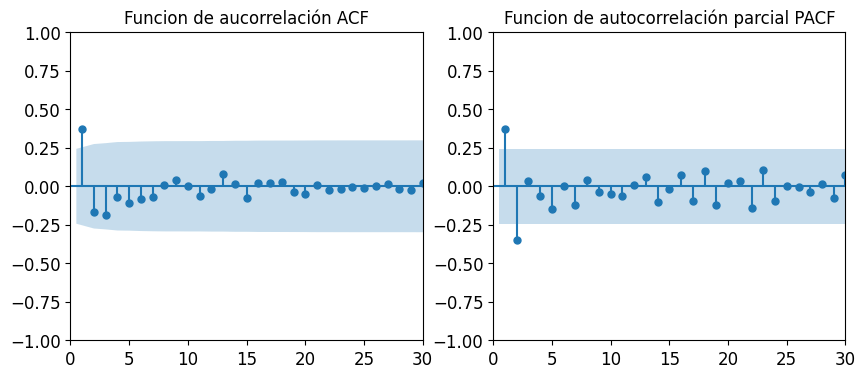

In [373]:
ig, ax = plt.subplots(1,2,figsize=(10,4))
# Primer subgrafica
plot_acf(IMCP_base['IMCM_DIFF'].dropna(),zero=False,lags=30,ax=ax[0],title='Funcion de aucorrelación ACF')
ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,30)
# Segunda subgrafica
plot_pacf(IMCP_base['IMCM_DIFF'].dropna(),zero=False,lags=30,ax=ax[1],title='Funcion de autocorrelación parcial PACF')
ax[1].set_ylim(-1,1)
ax[1].set_xlim(0,30)
plt.show()

En la primera grafica, estamos mirando cuánto se parecen o estan relacionados los valores de la serie en diferentes momentos en el tiempo. En el pico alto en esta grafica, nos da a entender que hay una correlación entre los valores en esos momentos.

La segunda grafica se enfoca en mirar la correlación que no se explica por los momentos intermedios. 

Ambas nos permiten entender como los valores de la serie  estan relacionados en el tiempo, al tener un pico alto entre el 0, podría decirse 1, se debe a que los datos son diarios, lo confirmamos en la serie

### e) Utiliza auto_arima para encontrar el orden del modelo arima, dando el parámetro information_criterion, prueba y muestra el resultado, con aic, bic, hqic, oob.

In [374]:
# Utilizano criterio AIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='aic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [375]:
# Utilizano criterio BIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='bic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [376]:
# Utilizano criterio HQIC
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='hqic',
              seasonal=False)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [377]:
# Utilizano criterio OOB
pm.auto_arima(IMCP_base['IMCM_DIFF'].dropna(),
              start_p= 1,
              start_q = 1,
              max_p=7, 
              max_q=7,
              information_criterion='oob',
              seasonal=False)

c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [378]:
criterios = ['aic', 'bic', 'hqic', 'oob']

for criterio in criterios:
    model = auto_arima(IMCP_base['IMCM_DIFF'].dropna(), information_criterion=criterio)
    print(f"Mejor modelo ARIMA con {criterio}: {model.summary()}")

Mejor modelo ARIMA con aic:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   65
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -147.290
Date:                Thu, 02 Nov 2023   AIC                            298.580
Time:                        21:01:13   BIC                            302.928
Sample:                    02-01-2018   HQIC                           300.295
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5039      0.060      8.376      0.000       0.386       0.622
sigma2         5.4174      0.351     15.435      0.000       4.730       6.105
Ljung-Box (L1) (Q):     

c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Mejor modelo ARIMA con oob:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   65
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -147.290
Date:                Thu, 02 Nov 2023   AIC                            298.580
Time:                        21:01:16   BIC                            302.928
Sample:                    02-01-2018   HQIC                           300.295
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5039      0.060      8.376      0.000       0.386       0.622
sigma2         5.4174      0.351     15.435      0.000       4.730       6.105
Ljung-Box (L1) (Q):     

### f) Utilizar el método del if con AR y MA para ver que modelos sugieren el BIC y el AIC

Suponer IMCM_DIFF es una AR(1) = ARMA(1,0) = ARIMA (1,0,0)

Estimaremos ARIMA (MCO)

In [379]:
modelo_prueba=ARIMA(IMCP_base['IMCM_DIFF'],order=(1,0,0))
resultado=modelo_prueba.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:              IMCM_DIFF   No. Observations:                   66
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -150.120
Date:                Thu, 02 Nov 2023   AIC                            306.239
Time:                        21:01:16   BIC                            312.808
Sample:                    01-01-2018   HQIC                           308.835
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1309      0.798      0.164      0.870      -1.434       1.696
ar.L1          0.3640      0.071      5.098      0.000       0.224       0.504
sigma2         5.9239      0.439     13.489      0.0

Suponer IMCM_DIFF es una AR(2) = ARMA(2,0) = ARIMA (2,0,0)

In [380]:
modelo_prueba=ARIMA(IMCP_base['IMCM_DIFF'],order=(2,0,0))
resultado2=modelo_prueba.fit()
print(resultado2.summary())

                               SARIMAX Results                                
Dep. Variable:              IMCM_DIFF   No. Observations:                   66
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -146.045
Date:                Thu, 02 Nov 2023   AIC                            300.090
Time:                        21:01:16   BIC                            308.849
Sample:                    01-01-2018   HQIC                           303.551
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1310      0.639      0.205      0.838      -1.122       1.383
ar.L1          0.4909      0.100      4.923      0.000       0.295       0.686
ar.L2         -0.3380      0.196     -1.723      0.0

In [381]:
# Debemos elegir el menor AIC
ic={}
for ar in range(7):
    for ma in range(7):
        print(f"AR:{ar}, MA={ma}")
        modelo = ARIMA(IMCP_base['IMCM_DIFF'],order=[ar,0 ,ma])
        resultado = modelo.fit()
        ic[(ar,ma)] = [resultado.aic,resultado.bic] 
ic = pd.DataFrame(ic,index=['AIC','BIC']).T
ic.index = ic.index.set_names(['AR','MA'])       

ic.sort_values('AIC').head(1)

AR:0, MA=0
AR:0, MA=1
AR:0, MA=2
AR:0, MA=3
AR:0, MA=4
AR:0, MA=5
AR:0, MA=6
AR:1, MA=0
AR:1, MA=1
AR:1, MA=2
AR:1, MA=3
AR:1, MA=4
AR:1, MA=5
AR:1, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=0
AR:2, MA=1
AR:2, MA=2
AR:2, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:2, MA=6
AR:3, MA=0
AR:3, MA=1
AR:3, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:3, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:3, MA=4
AR:3, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:3, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:4, MA=0
AR:4, MA=1


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:4, MA=3
AR:4, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:4, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:5, MA=0
AR:5, MA=1
AR:5, MA=2
AR:5, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:5, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:6, MA=0
AR:6, MA=1
AR:6, MA=2


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:6, MA=3


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR:6, MA=4


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:6, MA=5


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR:6, MA=6


c:\Users\yola\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,,AIC,BIC
AR,MA,,
2,0,300.090468,308.849087


### g) Con los dos incisos anteriores elegir el orden ARIMA a estimar

Las primeras diferencias del IMCM son un ARMA(2,1) = ARIMA (2,0,1)

### h) Estimar el modelo

In [392]:
model = ARIMA(IMCP_base['IMCM'], order=(2,1,1))
results=model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   IMCM   No. Observations:                   66
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -146.074
Date:                Thu, 02 Nov 2023   AIC                            300.148
Time:                        21:03:15   BIC                            308.846
Sample:                    01-01-2018   HQIC                           303.580
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3896      0.547      0.713      0.476      -0.682       1.461
ar.L2         -0.2988      0.246     -1.215      0.224      -0.781       0.183
ma.L1          0.1169      0.590      0.198      0.8

### i) Pronosticar tres periodos

In [393]:
results.predict('2023-07-01','2023-10-01')

2023-07-01    108.468120
2023-08-01    108.467733
2023-09-01    108.377943
2023-10-01    108.343076
Freq: MS, Name: predicted_mean, dtype: float64

### j) Mostrar en un print el pronóstico para agosto de 2023 con sus intervalos de confianza al 95%

In [394]:
# Obtener el intervalo de confianza de los pronosticos 
forecast = results.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [395]:
inicio= '2023-07-01'
final= '2023-10-01'
pronostico_valor = forecast_mean[inicio:final]
pronostico_intervalos = forecast_ci.loc[inicio:final]

In [396]:
df_pronostico = pd.DataFrame({'pronostico': pronostico_valor,
                              'limite inferior': pronostico_intervalos.iloc[:,0],
                              'limite superior': pronostico_intervalos.iloc[:,1]
                              })
df_pronostico

,pronostico,limite inferior,limite superior
2023-07-01,108.468120,103.994210,112.942030
2023-08-01,108.467733,100.378109,116.557356
2023-09-01,108.377943,98.133193,118.622692
2023-10-01,108.343076,96.747323,119.938830


In [397]:
ultima_obs

Periodos       2023/07
IMCM        108.209387
Name: 66, dtype: object